In [2]:
import numpy as np
from matplotlib import pyplot as plt
#from plot_parameters import FONT_SIZE, LEGEND_SIZE, FONT,  figsize
from noise_formulas import NEP_g, NEP_ph, S_I

figsize=(10,8)
#%run ../utils/python_utils.py
%run ../../plot_parameters.py

np.set_printoptions(precision=2)


In [3]:
# Read LiteBIRD detector parameters (reported on PTEP) from text file
v, dvfrac, popt, psat, tc, n  = np.loadtxt('LiteBIRD_PTEP_bolo_params.txt', skiprows=3, delimiter=',', dtype=float, usecols=(1,2,3,4,5,6), unpack=True)
dv = dvfrac*v
tb = 0.1

(0.0, 8.0)

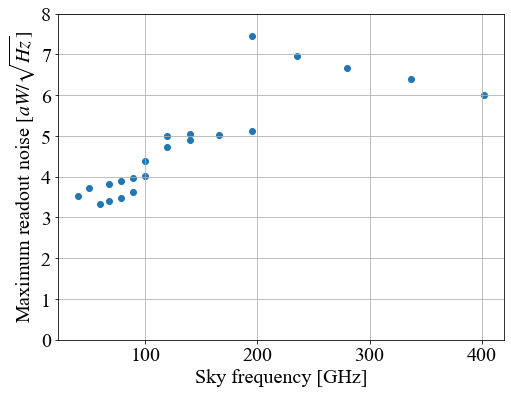

In [4]:
# calculate other noise sources
nep_g = NEP_g(psat, n, tb, tc) # phonon noise
nep_ph = NEP_ph(popt, v, dv) # photon noise
# calculate allowable readout NEP
nep_read_req = np.sqrt((nep_g**2 + nep_ph**2)*(1.1**2-1)) # same as NEP_read = 0.42 * sqrt(NEP_ph**2 + NEP_g**2)

plt.figure(1, figsize=(8, 6))
plt.scatter(v/1e9, nep_read_req*1e18)
plt.xlabel("Sky frequency [GHz]")
plt.ylabel("Maximum readout noise [$aW/\sqrt{Hz}]$")
plt.grid()
plt.ylim([0,8])

This is where assumptions about responsivity start to become important!

#CALCULATIONS COMPARING ASSUMPTIONS FROM NOTE 50 TO NICOLE'S in terms of NEP

(0.0, 8.0)

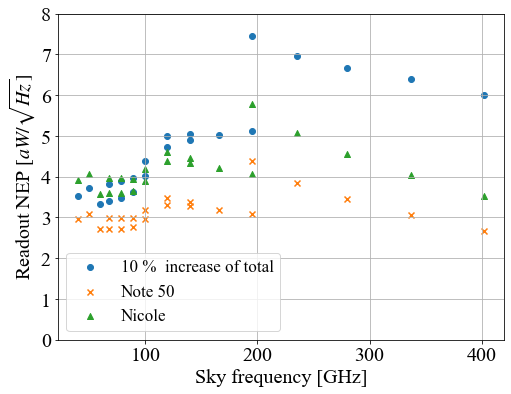

In [5]:
# Note 50 assumes infinite loop gain and excess responsivity
NEP_note_50 = 3.5e-18 * np.sqrt(popt/(0.5*1e-12))

# Nicole's assumptions
R_tes = 0.7
loop_gain = 10
P_bias = psat-popt
V_bias = np.sqrt(R_tes*P_bias)
s_I = np.sqrt(2) / V_bias * (loop_gain/(loop_gain+1))
NEP_nicole = 8.2e-12 /s_I

plt.figure(1, figsize=(8, 6))
plt.scatter(v/1e9, nep_read_req*1e18, label="10 %  increase of total")
plt.scatter(v/1e9, NEP_note_50*1e18, label='Note 50', marker="x")
plt.scatter(v/1e9, NEP_nicole*1e18, label='Nicole', marker="^")
plt.xlabel("Sky frequency [GHz]")
plt.ylabel("Readout NEP [$aW/\sqrt{Hz}]$")
plt.grid()
plt.legend()
plt.ylim([0,8])

### CALCULATIONS FOLLOWING TUCKER'S ASSUMPTIONS

In [6]:
rtes = np.array([1., 0.8, 0.7])
loopgain = 10
si = S_I(rtes[:, np.newaxis], psat-popt, loopgain)
nei_read_req = nep_read_req*si

In [7]:
print("NEPg [aW/sqrt(Hz)]")
print(nep_g*1e18)
print("NEP photon [aW/sqrt(Hz)]")
print(nep_ph*1e18)
print("NEP readout requirement [aW]/sqrt(Hz)")
print(nep_read_req*1e18)

NEPg [aW/sqrt(Hz)]
[4.37 4.   4.02 4.54 4.02 4.08 4.43 4.4  4.9  4.43 4.36 4.85 4.69 4.97
 4.54 5.15 4.71 6.46 5.09 5.68 4.53 3.94]
NEP photon [aW/sqrt(Hz)]
[ 6.35  6.07  6.45  6.74  6.24  6.79  7.09  7.46  9.06  7.28  7.63  9.53
  8.32  9.8  10.24  9.59  9.92 14.93 13.64 14.07 13.21 12.5 ]
NEP readout requirement [aW]/sqrt(Hz)
[3.53 3.33 3.48 3.72 3.4  3.63 3.83 3.97 4.72 3.9  4.03 4.9  4.37 5.04
 5.13 4.99 5.03 7.46 6.67 6.95 6.4  6.01]


In [8]:
for r, rt in enumerate(rtes):
    min_noise = np.min(nei_read_req[r, :])
    print("R: {:.2f}. Max noise: {:.2f} pA/sqrt(Hz)".format(rt, min_noise*1e12))

R: 1.00. Max noise: 6.20 pA/sqrt(Hz)
R: 0.80. Max noise: 6.93 pA/sqrt(Hz)
R: 0.70. Max noise: 7.41 pA/sqrt(Hz)


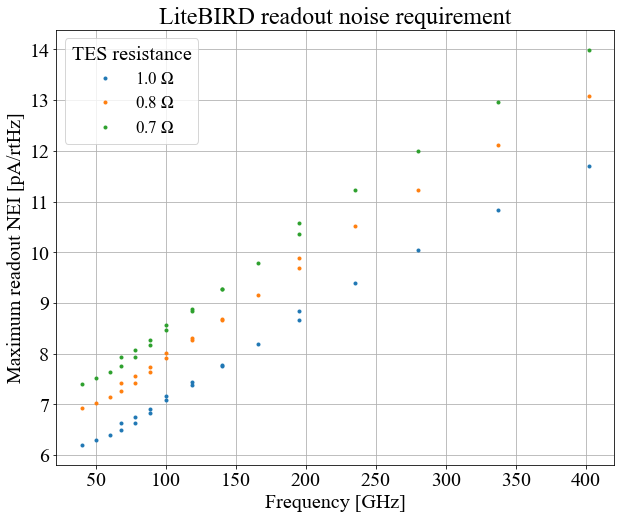

In [9]:
plt.figure(1, figsize=figsize)
plt.plot(v/1e9, nei_read_req[0]*1e12, '.', label=f'{rtes[0]} $\Omega$')
plt.plot(v/1e9, nei_read_req[1]*1e12, '.', label=f'{rtes[1]} $\Omega$')
plt.plot(v/1e9, nei_read_req[2]*1e12, '.', label=f'{rtes[2]} $\Omega$')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Maximum readout NEI [pA/rtHz]')
plt.title('LiteBIRD readout noise requirement')
plt.legend(title='TES resistance')
plt.grid(True)

I don't think it makes a lot of sense to use the noise requirement at 1 ohm with loop gain at 10. Let's plot thing per Rfrac per loopgain

In [10]:
index = np.argmin(nei_read_req)
nep_read_max = nep_read_req[index]
N1 = 100
N2 = 50
r_tes_array = np.linspace(0.3, 1, N1)
loop_gain_array = np.linspace(0, 12, N2)

nei_read_max_matrix = np.empty((N1, N2))

for rc, r in enumerate(r_tes_array):
    
    for lgc, lg in enumerate(loop_gain_array):
        si = S_I(r, psat[index]-popt[index], lg)
        nei_read_max = nep_read_max*si
        
        nei_read_max_matrix[rc, lgc] = nei_read_max
        
        

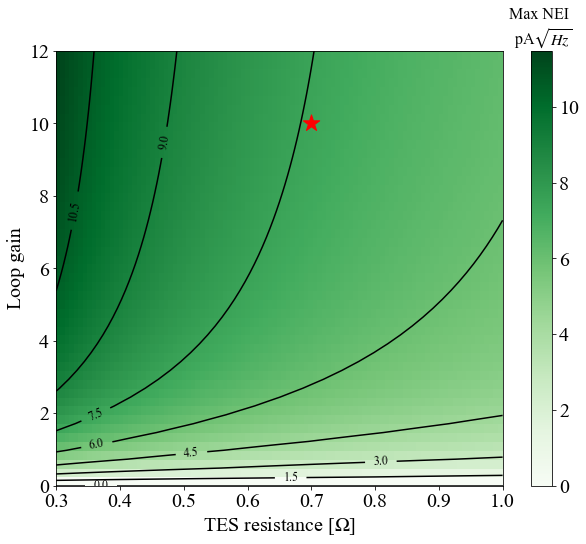

In [11]:
fig = plt.figure(12, figsize=figsize)

c = plt.pcolormesh( r_tes_array, loop_gain_array, np.transpose(nei_read_max_matrix*1e12), \
    cmap='Greens')

colorbar = fig.colorbar(c)
colorbar.ax.set_title('Max NEI \n pA$\sqrt{Hz}$', fontsize=16)
# add contours
contour = plt.contour(r_tes_array, loop_gain_array, np.transpose(nei_read_max_matrix*1e12), colors='black')
plt.clabel(contour, inline=True, fontsize=12, fmt='%2.1f')

plt.xlabel("TES resistance [$\\Omega$]")
plt.ylabel("Loop gain")

# point of interest
plt.scatter([0.7], [10], marker="*", s=300, color='red')


In [12]:
# But what is the noise at overbias?
V_overbiased = np.sqrt(psat[0])*1 # [V]
NEI_overbiased = nep_read_max / V_overbiased

print("Overbiased NEI: {:.1f} pA/sqrt(Hz)".format(NEI_overbiased*1e12))

Overbiased NEI: 3.7 pA/sqrt(Hz)


### See how this compares to achieved readout


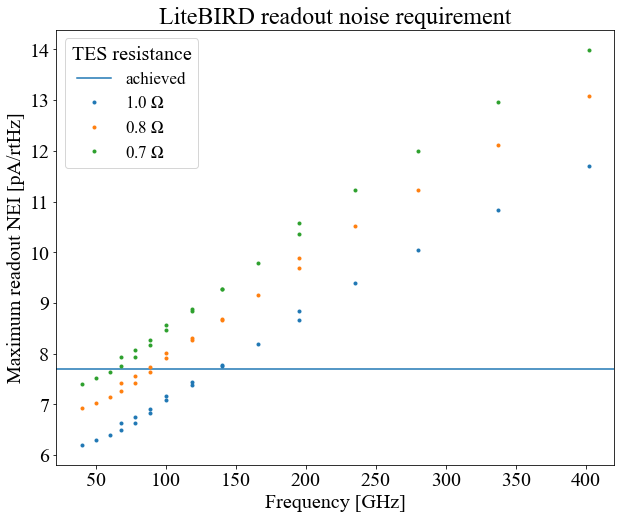

Rtes [ohms]    |    Achieved NEI / Min Required NEI 
   1.00        |               1.24  
   0.80        |               1.11  
   0.70        |               1.04  


In [13]:
# In terms of NEI
NEI_achieved = 7.7e-12 # A/sqrt(Hz) from an old presentation from Tucker

plt.figure(1, figsize=figsize)
plt.axhline(NEI_achieved*1e12, label="achieved")
plt.plot(v/1e9, nei_read_req[0]*1e12, '.', label=f'{rtes[0]} $\Omega$')
plt.plot(v/1e9, nei_read_req[1]*1e12, '.', label=f'{rtes[1]} $\Omega$')
plt.plot(v/1e9, nei_read_req[2]*1e12, '.', label=f'{rtes[2]} $\Omega$')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Maximum readout NEI [pA/rtHz]')
plt.title('LiteBIRD readout noise requirement')
plt.legend(title='TES resistance')
plt.show()


#print("Minimum NEI required: %.1f pA/sqrt(Hz) " %(np.min(nei_read_req[rc])*1e12 ))

print("Rtes [ohms]    |    Achieved NEI / Min Required NEI ")
for rc, r in enumerate(rtes):
    print("   %.2f        |               %.2f  " %(r, NEI_achieved / np.min(nei_read_req[rc])))

## In terms of NEP

In [32]:
R_tes = 1.0
loop_gain = 10
P_bias = psat-popt
V_bias = np.sqrt(R_tes*P_bias)
s_I = np.sqrt(2) / V_bias * (loop_gain/(loop_gain+1))

nep_read_achieved = NEI_achieved /(s_I) 

# Calculate increase in detector noise
nep_det_no_readout = np.sqrt((nep_g**2 + nep_ph**2))
nep_det_with_readout = np.sqrt((nep_g**2 + nep_ph**2 + nep_read_achieved**2 ))

print(nep_det_no_readout)
print(nep_det_with_readout)
print("Band [GHz]  | Increase in NEPdet [%]")
for i, band in enumerate(v):
    NEPdet_increase = round((nep_det_with_readout[i]-nep_det_no_readout[i])/nep_det_no_readout[i]*100)
    print("    %3d     |     %3d " %(round(band/1e9), NEPdet_increase) )


[7.71e-18 7.27e-18 7.60e-18 8.13e-18 7.42e-18 7.92e-18 8.36e-18 8.66e-18
 1.03e-17 8.52e-18 8.79e-18 1.07e-17 9.55e-18 1.10e-17 1.12e-17 1.09e-17
 1.10e-17 1.63e-17 1.46e-17 1.52e-17 1.40e-17 1.31e-17]
[8.87e-18 8.31e-18 8.61e-18 9.32e-18 8.44e-18 8.92e-18 9.47e-18 9.73e-18
 1.14e-17 9.61e-18 9.82e-18 1.17e-17 1.06e-17 1.21e-17 1.21e-17 1.20e-17
 1.20e-17 1.75e-17 1.54e-17 1.62e-17 1.47e-17 1.37e-17]
Band [GHz]  | Increase in NEPdet
     40     |      15 
     60     |      14 
     78     |      13 
     50     |      15 
     68     |      14 
     89     |      13 
     68     |      13 
     89     |      12 
    119     |      11 
     78     |      13 
    100     |      12 
    140     |      10 
    100     |      11 
    140     |      10 
    195     |       8 
    119     |      11 
    166     |       9 
    195     |       8 
    280     |       6 
    235     |       7 
    337     |       5 
    402     |       4 
